In [1]:
import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from importlib import reload


import data_generator

import models
import lightning_module

# Useful to reload modified external files without need
# of restarting the kernel. Just run again this cell.


reload(data_generator)


reload(models)
reload(lightning_module)


from data_generator import AllDataset,NormalizePair

from models import *

import torch.nn as nn
import torch.nn.functional as F
import torch
import gc
from matplotlib import pyplot as plt
from math import log10
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger, CSVLogger
from pytorch_lightning import Trainer
from lightning_module import ESRGANLightning
from pytorch_lightning.callbacks import ModelCheckpoint
from torchsummary import summary
import random


gc.collect()
torch.cuda.empty_cache() 
torch.set_float32_matmul_precision('high') # Set precision for matmul operations to 'high' for better performance


# Set the seed for reproducibility
SEED = 42
BATCH_SIZE = 1
NUM_WORKERS = 4
ROOT_DIR = "/home/debwa/Desktop/courses/ss25/FINAL_DL/Dataset/Dataset_5678"
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)


NORMALIZE_MEAN_LR = [0.0]*4
NORMALIZE_STD_LR  = [1.0]*4

NORMALIZE_MEAN_HR = [0.0]*4
NORMALIZE_STD_HR  = [1.0]*4


lr_transform = transforms.Compose([
    # transforms.Resize(FIXED_LR_SIZE),
    transforms.ToTensor()
])

hr_transform = transforms.Compose([
    # transforms.Resize(FIXED_HR_SIZE),
    transforms.ToTensor()])

train_dataset = AllDataset(
    root_dir=ROOT_DIR,
    split='train',
    transform=NormalizePair(NORMALIZE_MEAN_LR, NORMALIZE_STD_LR, NORMALIZE_MEAN_HR, NORMALIZE_STD_HR),
    augmentations=None
)
val_dataset = AllDataset(
    root_dir=ROOT_DIR,
    split='val',
    transform=NormalizePair(NORMALIZE_MEAN_LR, NORMALIZE_STD_LR, NORMALIZE_MEAN_HR, NORMALIZE_STD_HR),
    augmentations=None
)
test_dataset = AllDataset(
    root_dir=ROOT_DIR,
    split='test',
    transform=NormalizePair(NORMALIZE_MEAN_LR, NORMALIZE_STD_LR, NORMALIZE_MEAN_HR, NORMALIZE_STD_HR),
    augmentations=None
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    generator=generator
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    generator=generator
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    generator=generator
)


config_dict = {
    'scale_factor': 4,
    'lr': 0.0002,
    'b1': 0.9,
    'b2': 0.999,
    'hr_height': 256,
    'hr_width': 256,
    'channels': 4,  # Number of channels in the input images
    'residual_blocks': 23, # Number of residual blocks in the generator
    'discriminator_filters': [64, 128, 128, 256], # Filters for the discriminator
    'warmup_batches': 500,
    'lambda_adv': 0.005,
    'lambda_pixel': 0.01,
    'lambda_content': 0.01, # Content loss weight L1 weight
    'vgg19_path': "/home/debwa/Desktop/courses/ss25/FINAL_DL/Pretained/vgg19.pth",
    'NORMALIZE_MEAN_HR': NORMALIZE_MEAN_HR,
    'NORMALIZE_STD_HR': NORMALIZE_STD_HR,
    'images_saved_dir': "images/validation",
    'saved_models_dir': "saved_models",
    'lr_scheduler_step_size': 100000,
    'lr_scheduler_gamma': 0.5,
    'use_channel_attention': True,
    'vgg19_channels': 3  # Set to 3 for RGB input to VGG19
}



model = ESRGANLightning(config_dict)

checkpoint_callback = ModelCheckpoint(
    monitor='val/psnr',
    dirpath='saved_models',
    filename='model_{epoch:02d}_psnr_{val/psnr:.2f}',
    save_top_k=5,
    mode='max'
)
logger = CSVLogger("logs", name="esrgan_experiment")
trainer = Trainer(
    default_root_dir=os.getcwd(),
    max_epochs=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10,
    logger=logger,
    callbacks=[checkpoint_callback]
)
CKPT_PATH = None  # Path to a checkpoint if you want to resume training
# trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path=CKPT_PATH)




/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] Received config dict with keys: dict_keys(['scale_factor', 'lr', 'b1', 'b2', 'hr_height', 'hr_width', 'channels', 'residual_blocks', 'discriminator_filters', 'warmup_batches', 'lambda_adv', 'lambda_pixel', 'lambda_content', 'vgg19_path', 'NORMALIZE_MEAN_HR', 'NORMALIZE_STD_HR', 'images_saved_dir', 'saved_models_dir', 'lr_scheduler_step_size', 'lr_scheduler_gamma', 'use_channel_attention', 'vgg19_channels'])


/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/debwa/Desktop/courses/ss25/GITHUB/cleaned_repo/Final_Project/03-Code/ESRGAN/B_5678/lightning_module.py:49: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

In [2]:

# print(summary(model, input_size=(4, 256, 256), device="cpu"))

In [6]:
## FOR INFERENCE
test_model = ESRGANLightning(config_dict)
generator_path = "checkpoints/generator_epoch_170.pth" 
test_model.generator.load_state_dict(torch.load(generator_path, map_location='cpu'))


[DEBUG] Received config dict with keys: dict_keys(['scale_factor', 'lr', 'b1', 'b2', 'hr_height', 'hr_width', 'channels', 'residual_blocks', 'discriminator_filters', 'warmup_batches', 'lambda_adv', 'lambda_pixel', 'lambda_content', 'vgg19_path', 'NORMALIZE_MEAN_HR', 'NORMALIZE_STD_HR', 'images_saved_dir', 'saved_models_dir', 'lr_scheduler_step_size', 'lr_scheduler_gamma', 'use_channel_attention', 'vgg19_channels'])


/tmp/ipykernel_12703/303938848.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.generator.load_state_dict(torch.load(generator_path, map_location='cpu'))


<All keys matched successfully>

In [ ]:
from torchmetrics.functional.image import peak_signal_noise_ratio as tm_psnr
from torchmetrics.functional.image import structural_similarity_index_measure as tm_ssim
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity


def _prep_for_lpips(tensor, bands=None, crop_size=None):
    """
    Ensure tensor shape [N,3,H,W] for LPIPS.
    - tensor: [N,C,H,W]
    - bands: list/tuple of 3 ints selecting channels from C (preferred)
    - crop_size: (h,w) or int for square center crop (optional)
    """
    N, C, H, W = tensor.shape

    # select bands if explicitly provided
    if bands is not None:
        if len(bands) != 3:
            raise ValueError("lpips bands must be length 3")
        tensor = tensor[:, list(bands), :, :]
    else:
        # fallback rules:
        if C == 3:
            pass  # fine
        elif C == 1:
            tensor = tensor.repeat(1, 3, 1, 1)
        elif C == 2:
            # replicate first channel to make 3
            tensor = torch.cat([tensor, tensor[:, :1, :, :]], dim=1)
        else:
            # C > 3: take first 3 channels by default
            tensor = tensor[:, :3, :, :]

    # optional center crop (reduces memory & speeds up LPIPS)
    if crop_size is not None:
        if isinstance(crop_size, int):
            ch = cw = crop_size
        else:
            ch, cw = crop_size
        if ch > tensor.shape[2] or cw > tensor.shape[3]:
            # if requested crop larger than image, resize first
            tensor = F.interpolate(tensor, size=(max(ch, tensor.shape[2]), max(cw, tensor.shape[3])),
                                   mode='bilinear', align_corners=False)
        Ht, Wt = tensor.shape[2], tensor.shape[3]
        top = (Ht - ch) // 2
        left = (Wt - cw) // 2
        tensor = tensor[:, :, top:top + ch, left:left + cw]

    return tensor.contiguous()

def compute_psnr_ssim_lpips(
    gen,
    test_loader,
    every_n_for_ssim=5,
    every_n_for_lpips=5,
    lpips_net_type='vgg',
    lpips_normalize=True,
    lpips_bands=None,        # e.g. [0,1,2] to pick RGB-like bands from your C-channel data
    lpips_crop_size=None     # int or (h,w) center crop for LPIPS (speeds up + saves memory)
):
    device = next(gen.parameters()).device
    gen.eval()

    psnr_sum = 0.0
    ssim_sum = 0.0
    lpips_sum = 0.0

    psnr_count = 0
    ssim_count = 0
    lpips_count = 0

    torch.backends.cudnn.benchmark = True

    lpips_metric = LearnedPerceptualImagePatchSimilarity(
        net_type=lpips_net_type, normalize=lpips_normalize
    ).to(device)
    lpips_metric.eval()

    with torch.inference_mode():
        for b, batch in enumerate(test_loader):
            lr = batch['lr'].to(device, non_blocking=True)
            hr = batch['hr'].to(device, non_blocking=True)

            sr = gen(lr)
            # synchronize sizes if needed
            if sr.shape[-2:] != hr.shape[-2:]:
                hr = hr[..., :sr.shape[-2], :sr.shape[-1]]

            sr = torch.clamp(sr, 0, 1)
            hr = torch.clamp(hr, 0, 1)

            # PSNR
            psnr_batch = tm_psnr(sr, hr, data_range=1.0)
            if psnr_batch.ndim > 0:
                psnr_sum += psnr_batch.sum()
                psnr_count += psnr_batch.numel()
            else:
                psnr_sum += psnr_batch
                psnr_count += 1

            # SSIM (sparse)
            if (b % every_n_for_ssim) == 0:
                ssim_batch = tm_ssim(sr, hr, data_range=1.0, kernel_size=11, sigma=1.5)
                if ssim_batch.ndim > 0:
                    ssim_sum += ssim_batch.sum()
                    ssim_count += ssim_batch.numel()
                else:
                    ssim_sum += ssim_batch
                    ssim_count += 1

            # LPIPS (sparse). Prepare channels to be exactly 3.
            if (b % every_n_for_lpips) == 0:
                sr_lpips = _prep_for_lpips(sr, bands=lpips_bands, crop_size=lpips_crop_size)
                hr_lpips = _prep_for_lpips(hr, bands=lpips_bands, crop_size=lpips_crop_size)

                # sanity: shapes must match
                assert sr_lpips.shape == hr_lpips.shape, (sr_lpips.shape, hr_lpips.shape)

                lpips_batch = lpips_metric(sr_lpips, hr_lpips)
                if lpips_batch.ndim > 0:
                    lpips_sum += lpips_batch.sum()
                    lpips_count += lpips_batch.numel()
                else:
                    lpips_sum += lpips_batch
                    lpips_count += 1

    avg_psnr = (psnr_sum / max(psnr_count, 1)).item()
    avg_ssim = (ssim_sum / max(ssim_count, 1)).item() if ssim_count else float('nan')
    avg_lpips = (lpips_sum / max(lpips_count, 1)).item() if lpips_count else float('nan')

    print(f"Average PSNR: {avg_psnr:.2f} dB")
    if ssim_count:
        print(f"Average SSIM: {avg_ssim:.4f}")
    else:
        print("SSIM: (computed sparsely)")

    if lpips_count:
        print(f"Average LPIPS ({lpips_net_type}): {avg_lpips:.4f}  (lower is better)")
    else:
        print("LPIPS: (computed sparsely)")

    return avg_psnr, avg_ssim, avg_lpips


In [8]:
# Move generator to GPU/CPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen = test_model.generator.to(device).eval()

In [9]:
compute_psnr_ssim_lpips(gen, test_loader, lpips_bands=[2,1,0])

/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.

Average PSNR: 37.50 dB
Average SSIM: 0.9278
Average LPIPS (vgg): 0.1786  (lower is better)


(37.5000114440918, 0.9277633428573608, 0.1786395013332367)

In [10]:
compute_psnr_ssim_lpips(gen, test_loader, lpips_bands=[3,2,1])

Average PSNR: 37.50 dB
Average SSIM: 0.9278
Average LPIPS (vgg): 0.1543  (lower is better)


(37.5000114440918, 0.9277633428573608, 0.1542581170797348)

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure,LearnedPerceptualImagePatchSimilarity

def apply_contrast_stretch(img_chw, p1=2, p2=98):
    img_min = np.percentile(img_chw, p1, axis=(1, 2), keepdims=True)
    img_max = np.percentile(img_chw, p2, axis=(1, 2), keepdims=True)
    stretched = (img_chw - img_min) / (img_max - img_min + 1e-6)
    return np.clip(stretched, 0, 1)

@torch.no_grad()
def visualize_sr_triplets(model, test_loader, band_combination='2x', num_samples=3, dpi=150):
    band_configs = {
        '4x': {'display_bands': [3, 2, 1], 'label': "10m → 5m"},
        '2x': {'display_bands': [2, 1, 0], 'label': "10m → 5m"},
    }
    config = band_configs.get(band_combination.lower())
    if not config:
        raise ValueError("band_combination must be '2x' or '4x'.")

    device = next(model.parameters()).device
    model.eval().to(device)

    psnr_method = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_method = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    # NEW: LPIPS (normalize=True maps [0,1] -> [-1,1] internally)
    lpips_method = LearnedPerceptualImagePatchSimilarity(
        net_type='vgg', normalize=True
    ).to(device)

    shown = 0
    for batch in test_loader:
        if shown >= num_samples:
            break

        lr = batch['lr'].to(device)   # (B,C,H,W)
        hr = batch['hr'].to(device)   # (B,C,H,W)

        sr = model(lr)                # (B,C,H,W)
        sr = torch.clamp(sr, 0, 1)
        hr = torch.clamp(hr, 0, 1)

        lr_up = F.interpolate(lr, size=hr.shape[-2:], mode='bilinear', align_corners=False)

        bands = torch.as_tensor(config['display_bands'], device=device)

        for i in range(lr.size(0)):
            if shown >= num_samples:
                return

            # ---- METRICS on tensors (NCHW) ----
            sr_eval = sr[i, bands][None, ...]  # (1,3,H,W)
            hr_eval = hr[i, bands][None, ...]  # (1,3,H,W)

            psnr = psnr_method(sr_eval, hr_eval).item()
            ssim_val = ssim_method(sr_eval, hr_eval).item()
            # NEW:
            lpips_val = lpips_method(sr_eval, hr_eval).item()

            # ---- VISUALS (NumPy, contrast-stretched) ----
            def to_disp(t_chw):
                np_chw = t_chw.detach().cpu().numpy()
                np_chw = apply_contrast_stretch(np_chw)     # (C,H,W)
                return np.transpose(np_chw, (1, 2, 0))      # (H,W,C)

            lr_img = to_disp(lr_up[i, bands])
            sr_img = to_disp(sr[i, bands])
            hr_img = to_disp(hr[i, bands])

            titles = [
                f"LR (upsampled)  {lr_img.shape[1]}×{lr_img.shape[0]}",
                # UPDATED: include LPIPS (lower = better)
                f"SR  PSNR: {psnr:.2f} | SSIM: {ssim_val:.3f} | LPIPS: {lpips_val:.3f}",
                f"HR (GT)  {hr_img.shape[1]}×{hr_img.shape[0]}",
            ]
            imgs = [lr_img, sr_img, hr_img]

            plt.figure(figsize=(18, 6), dpi=dpi)
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.imshow(imgs[j])
                plt.title(titles[j])
                plt.axis('off')
            plt.suptitle(config['label'], fontsize=13)
            plt.tight_layout()
            plt.show()

            shown += 1

/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.

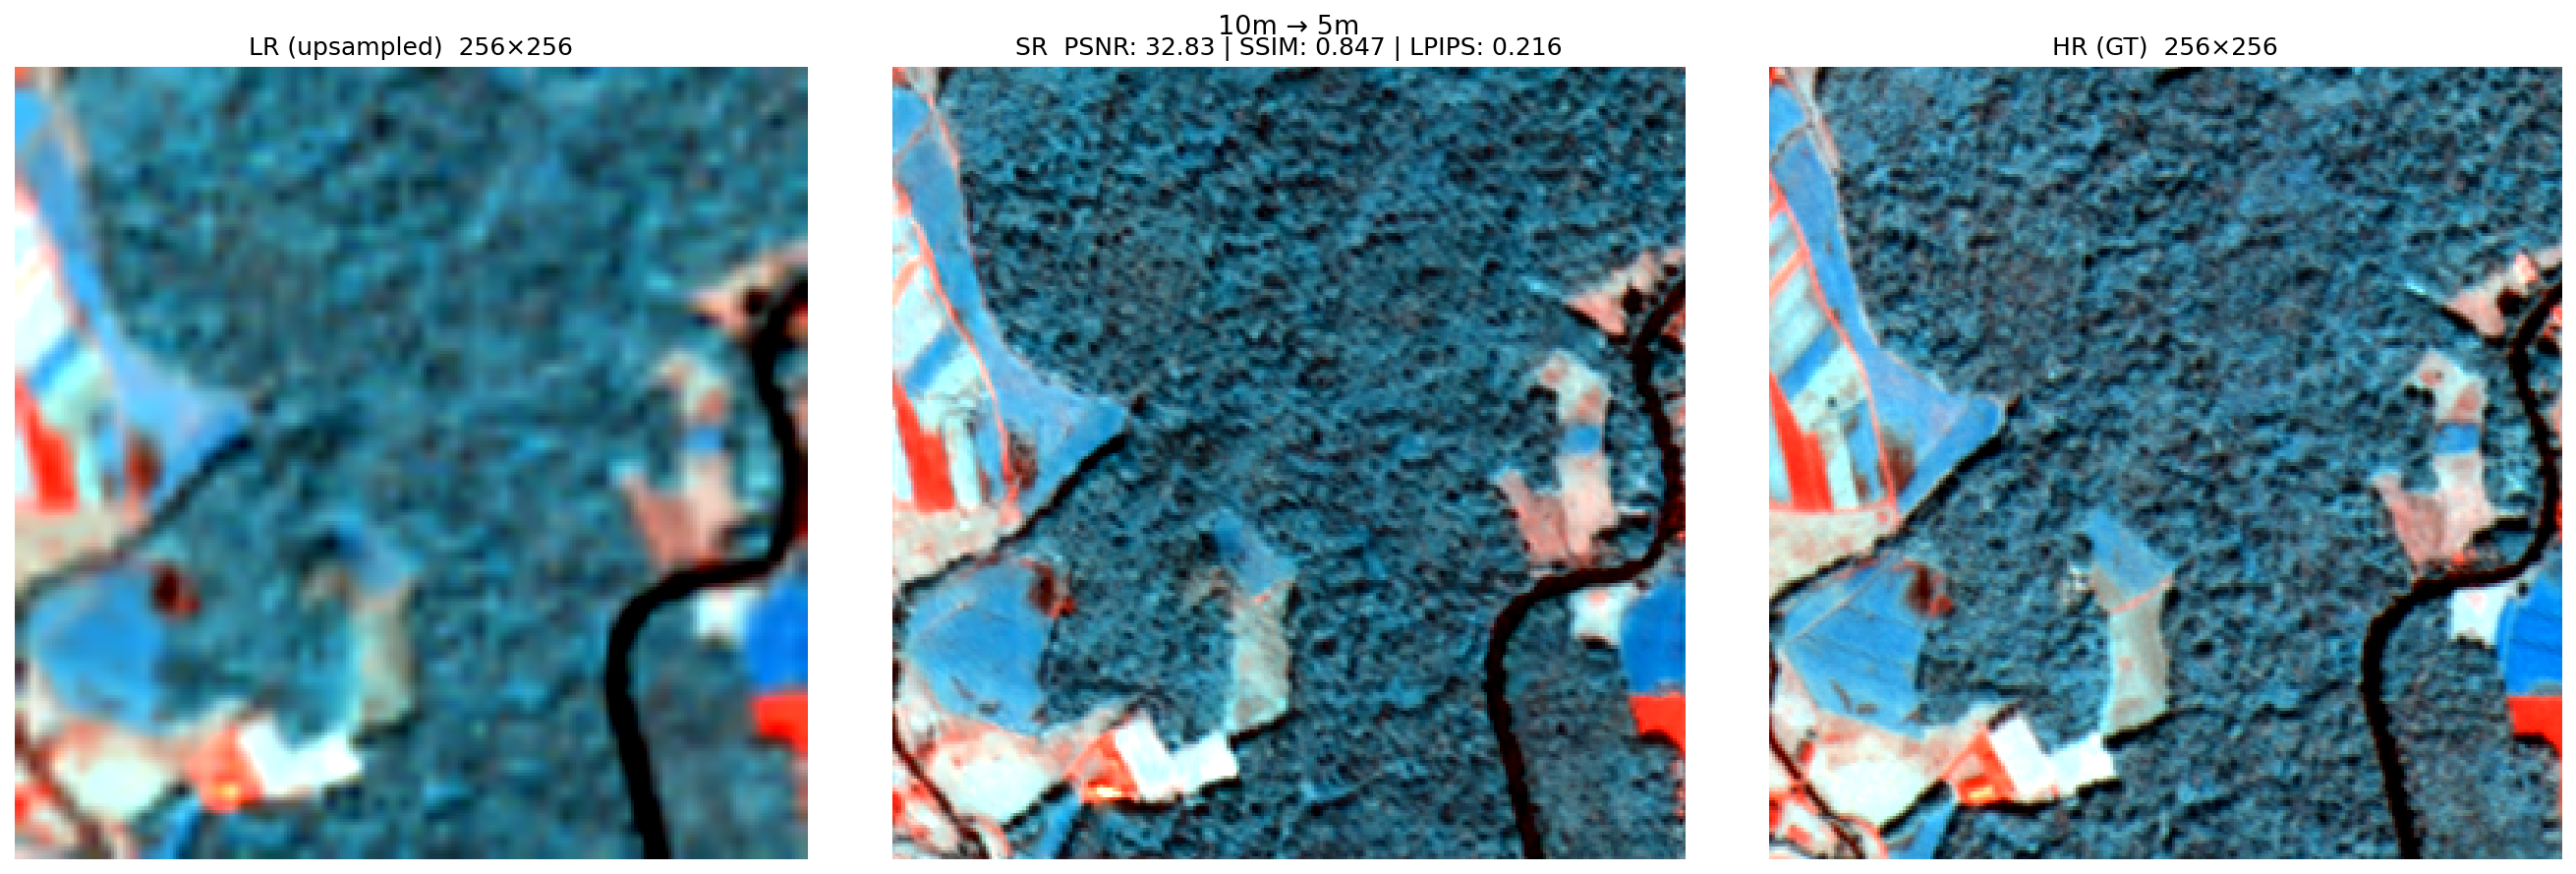

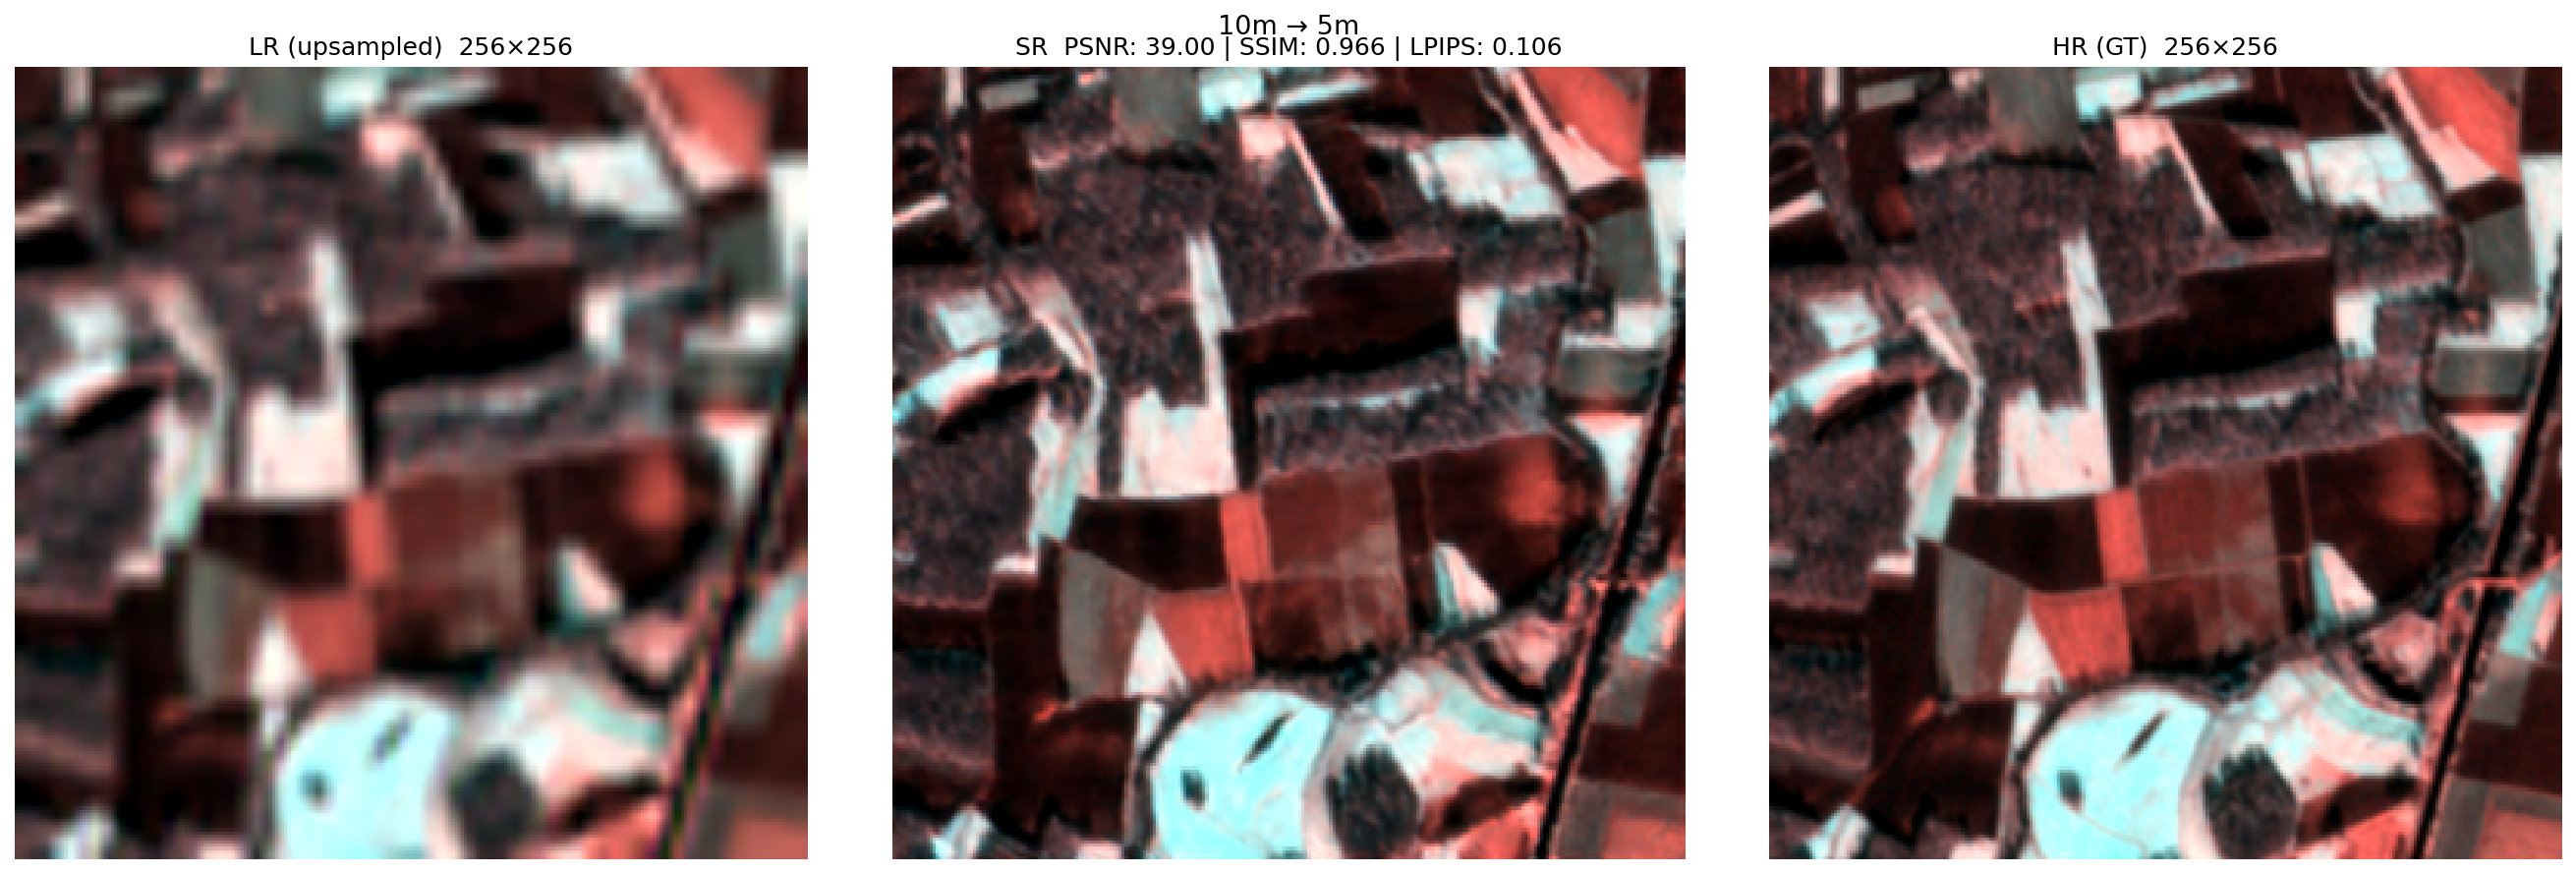

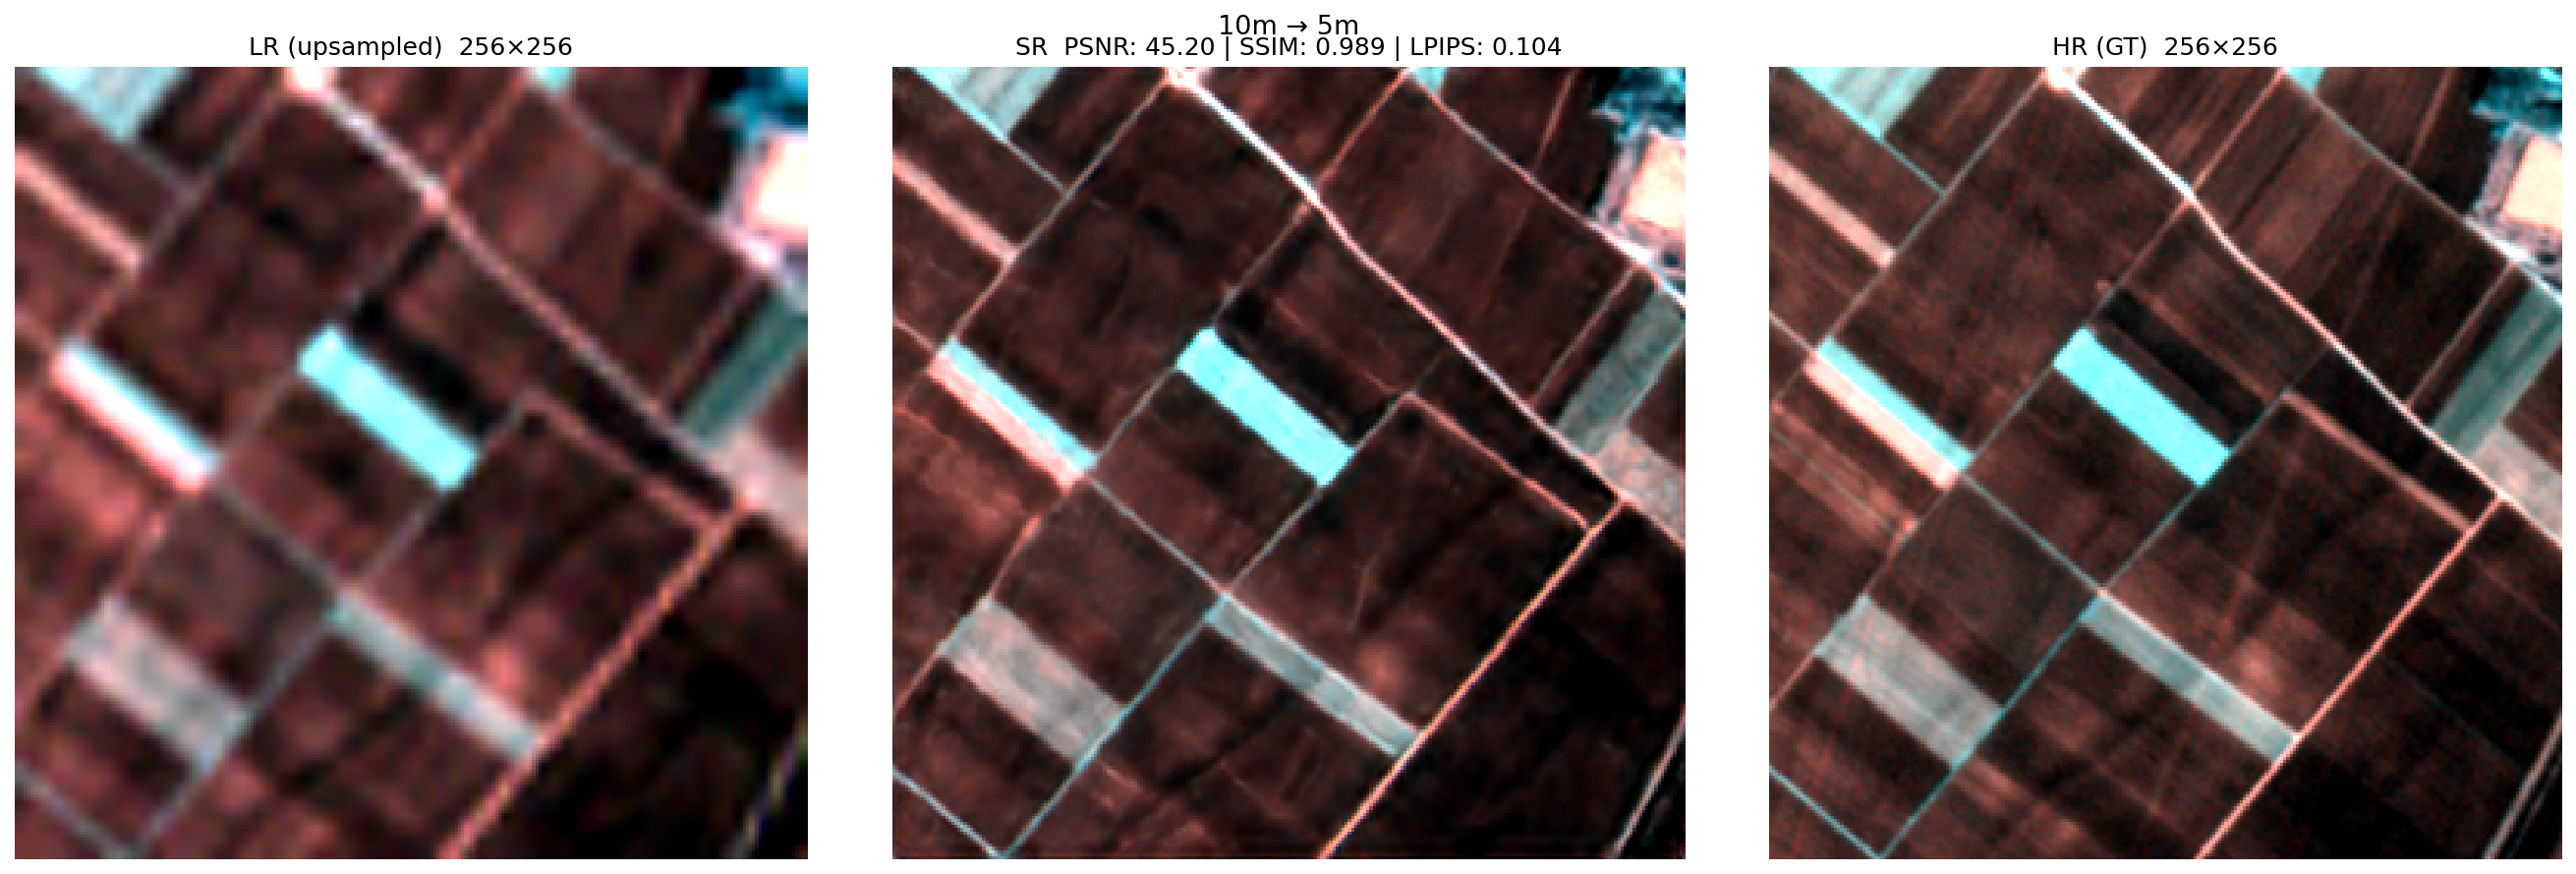

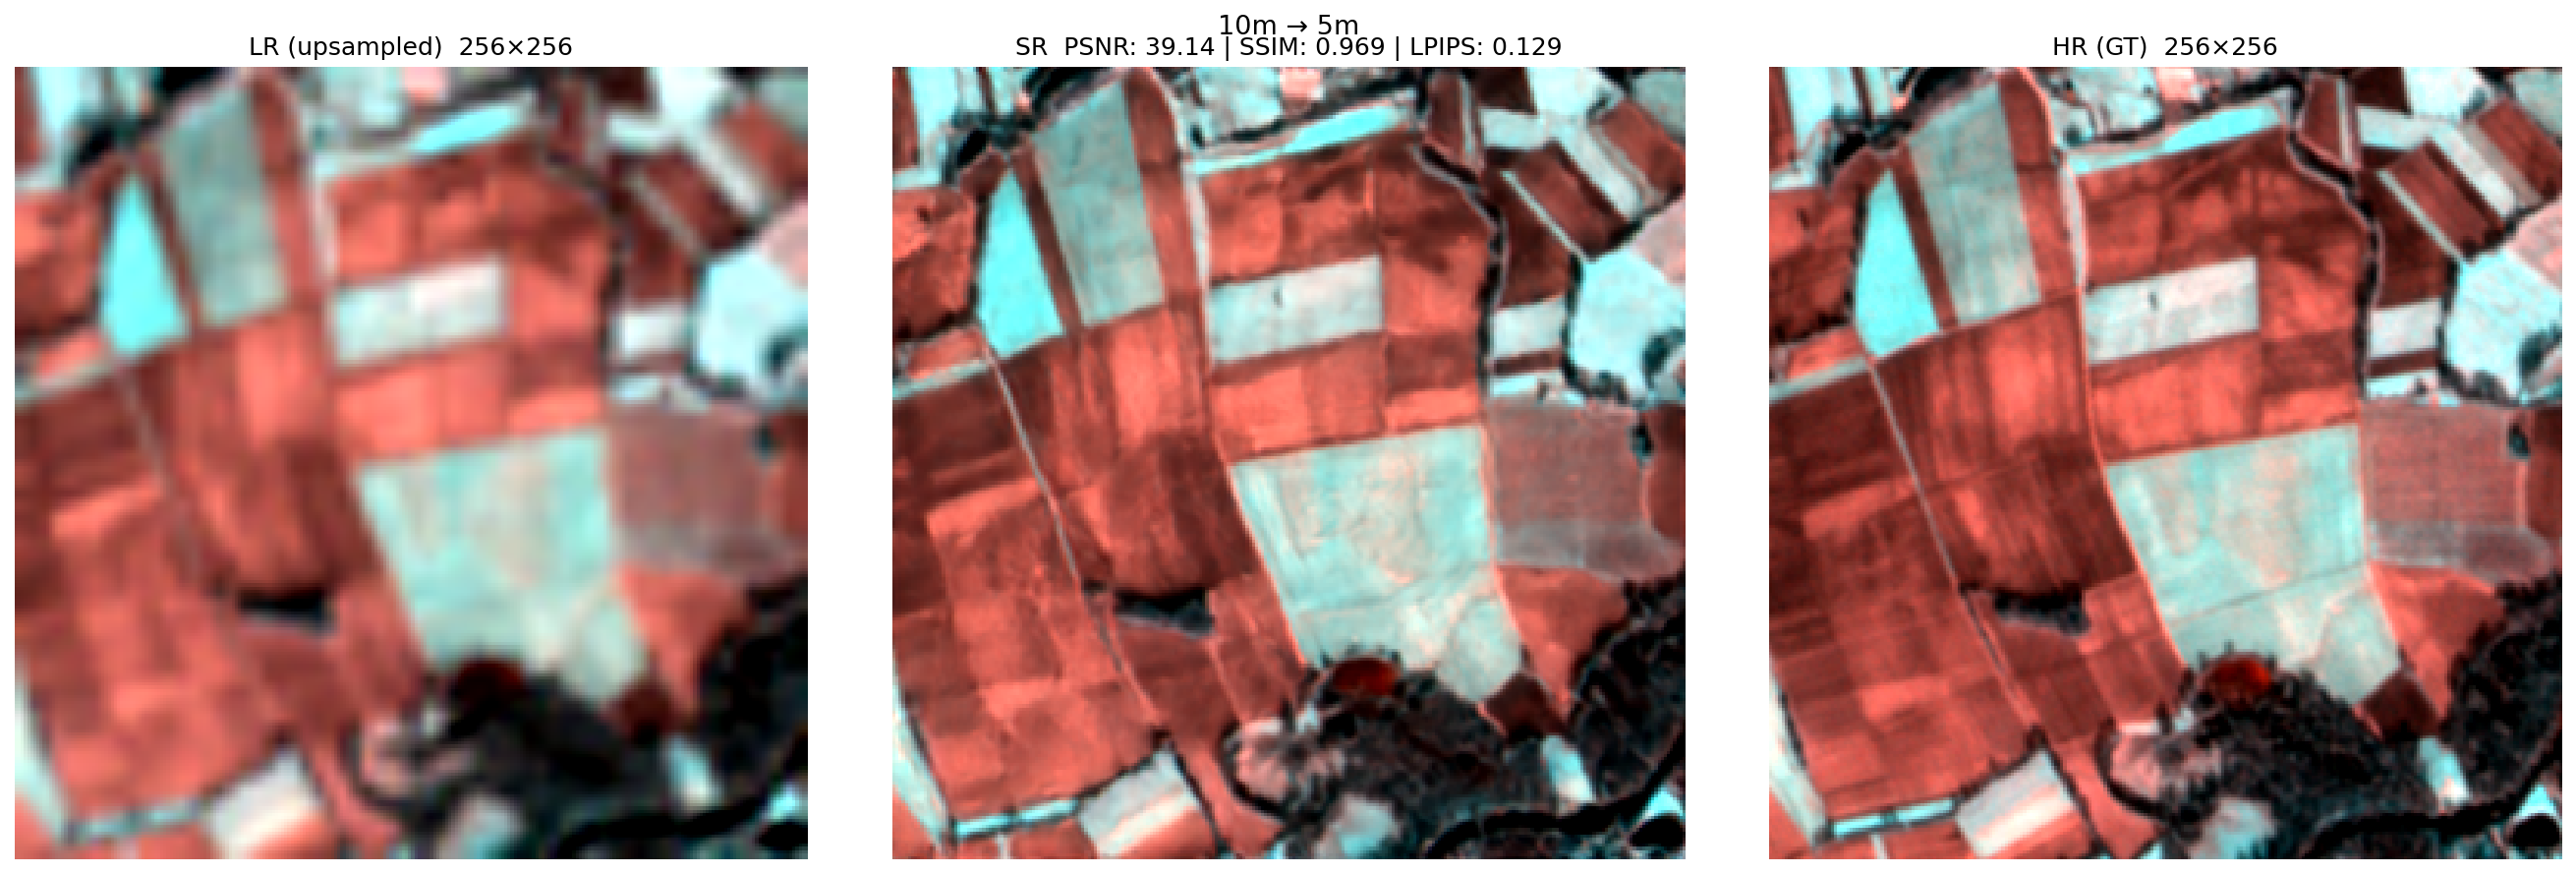

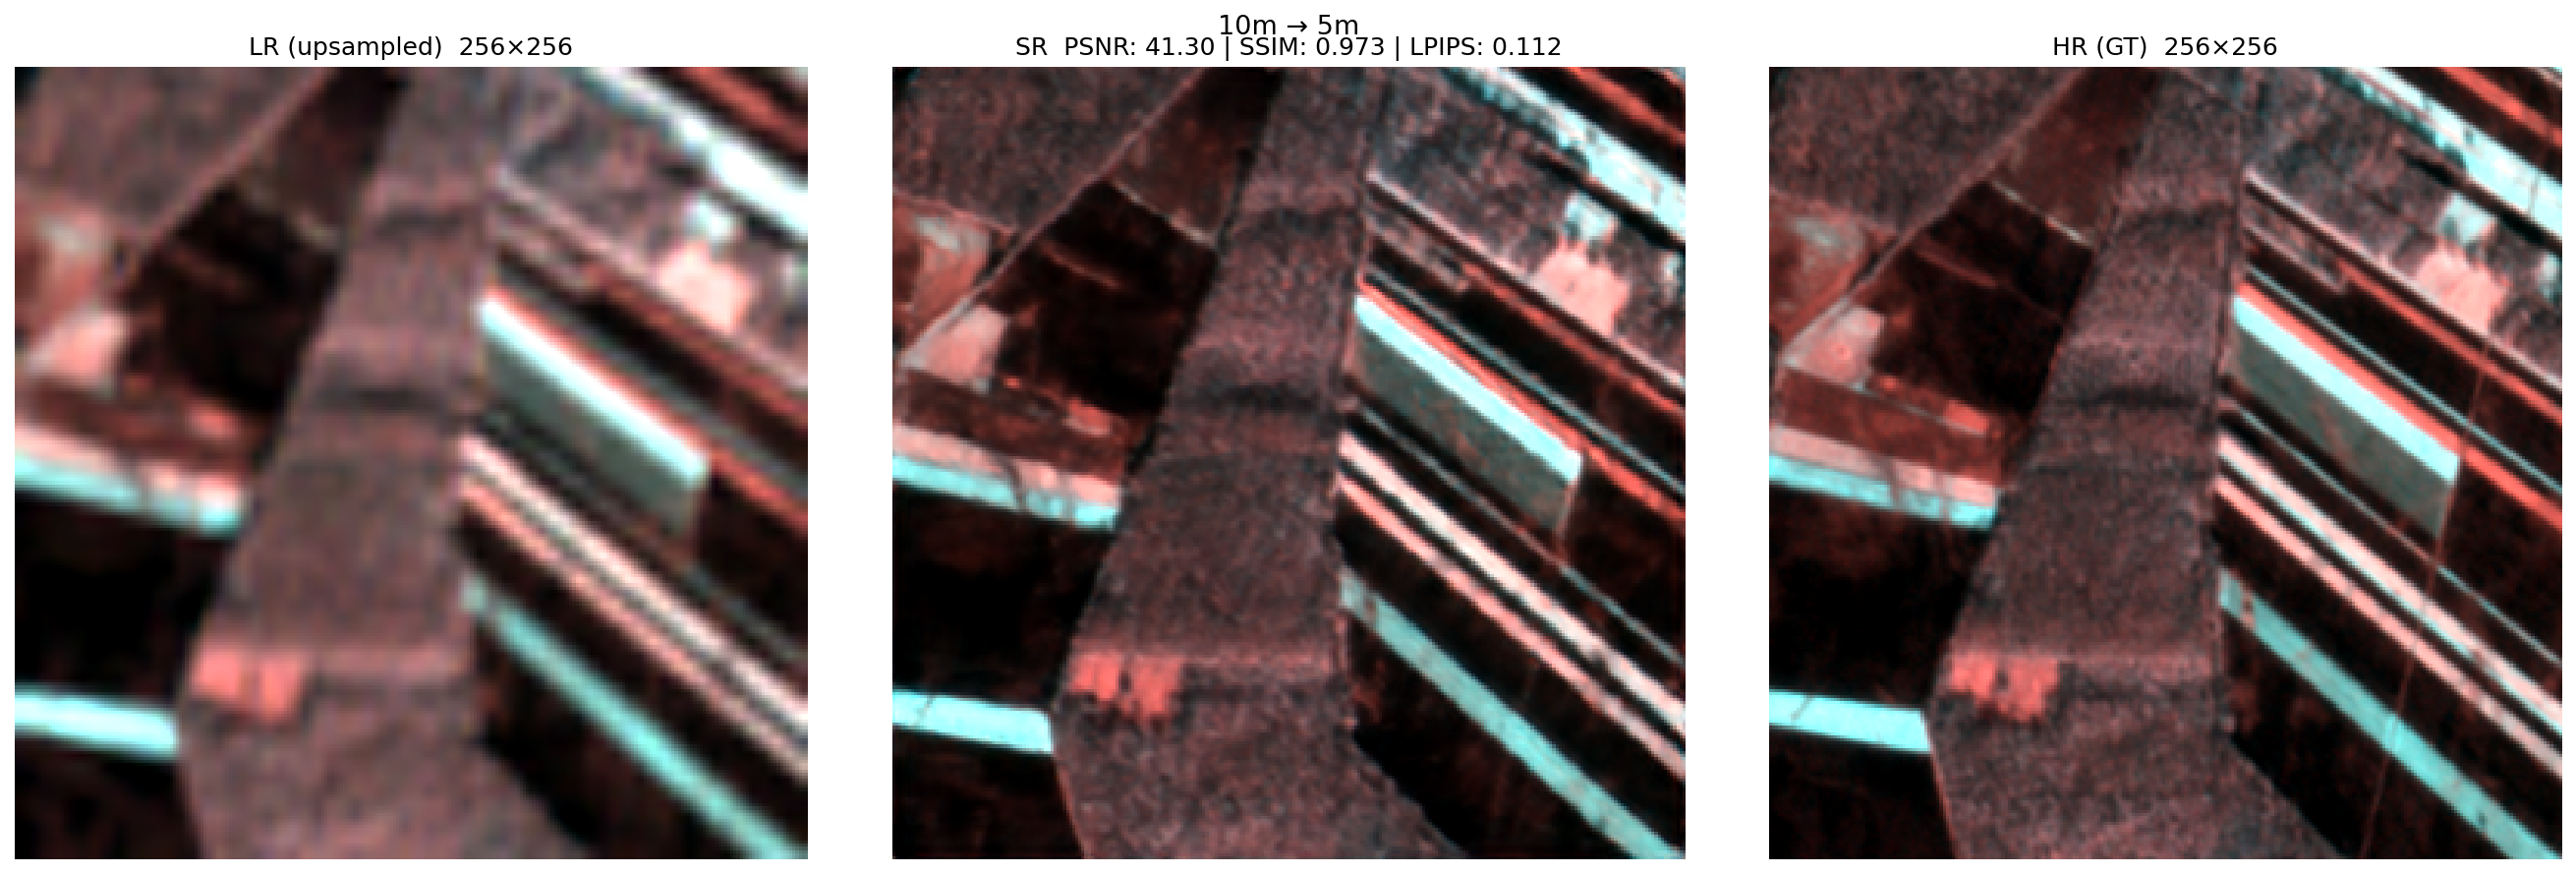

In [14]:
visualize_sr_triplets(gen, test_loader, band_combination='2x', num_samples=5, dpi=150)

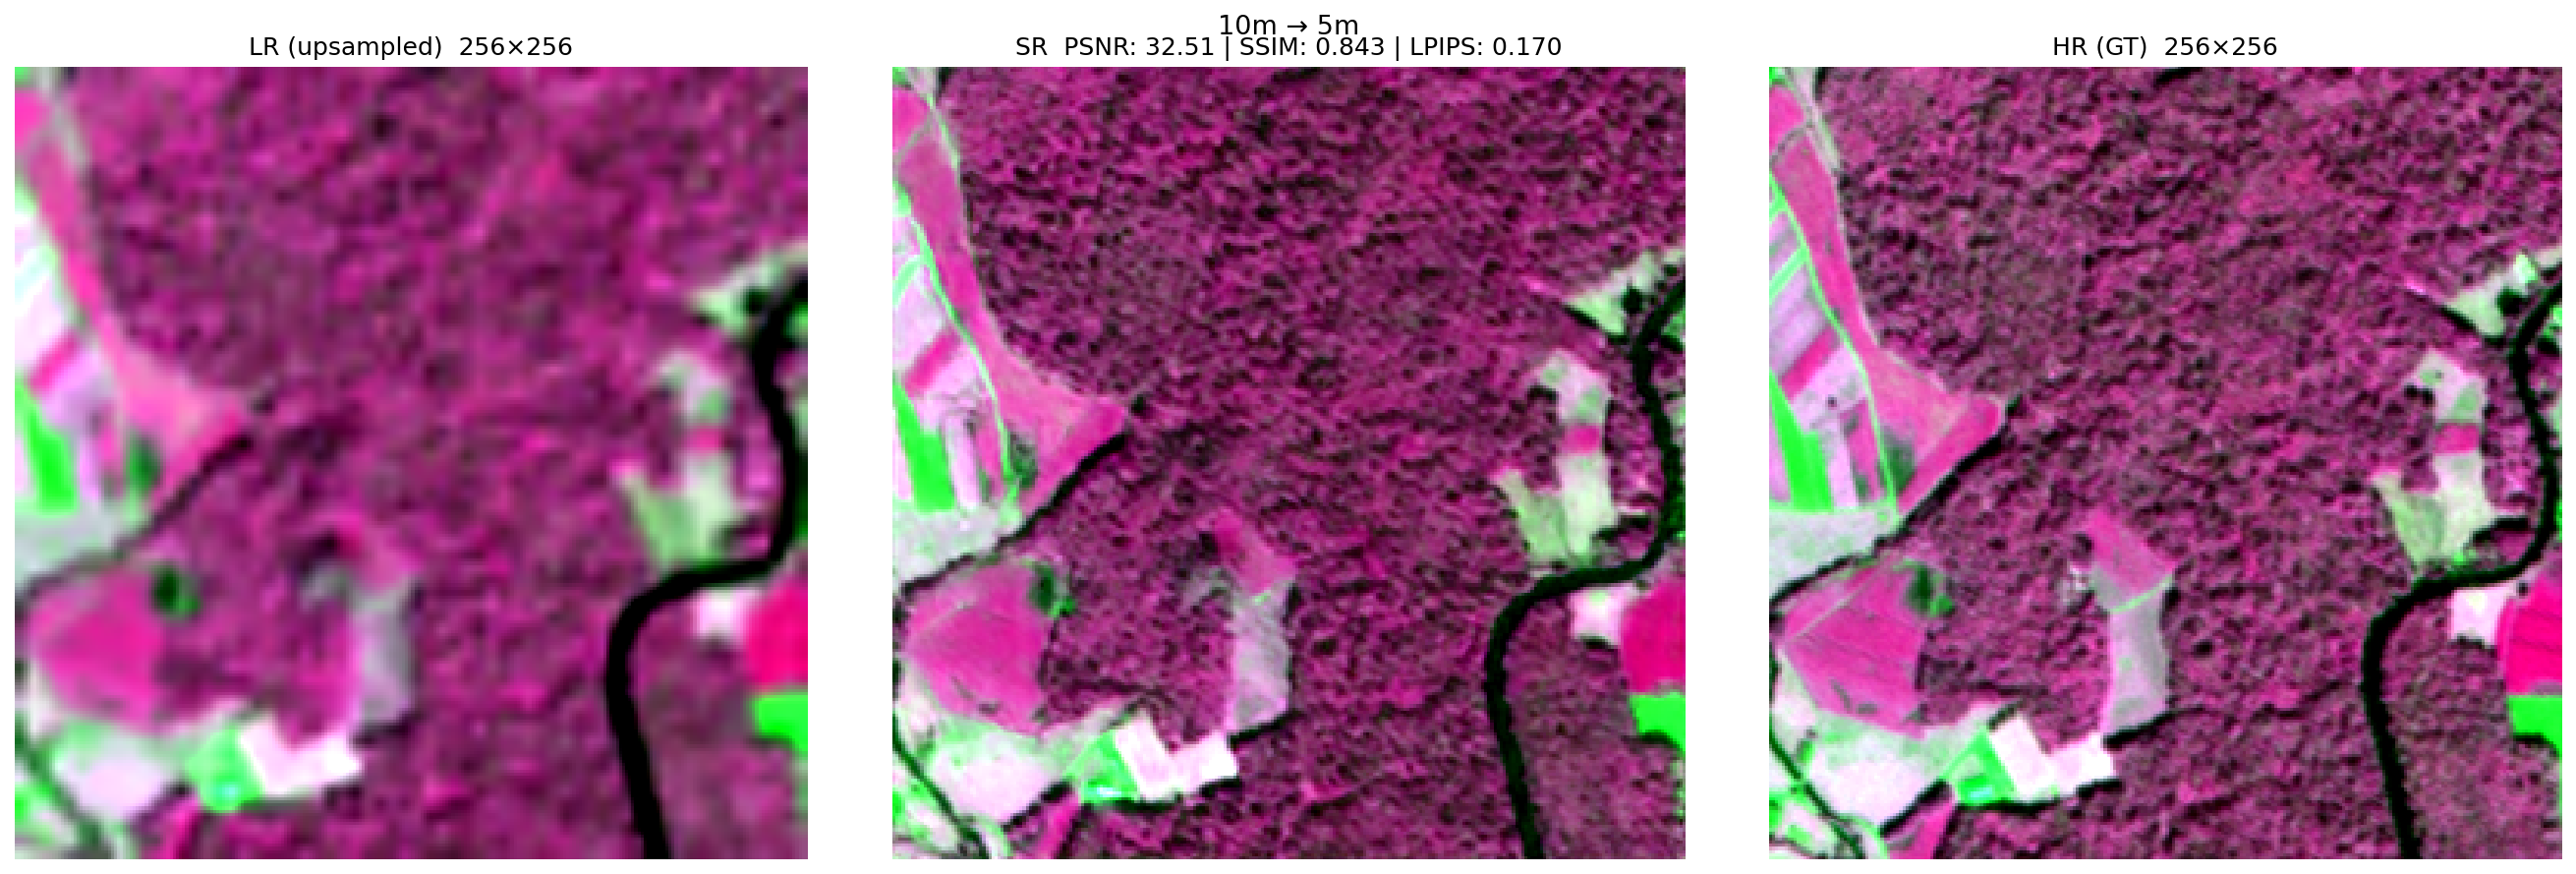

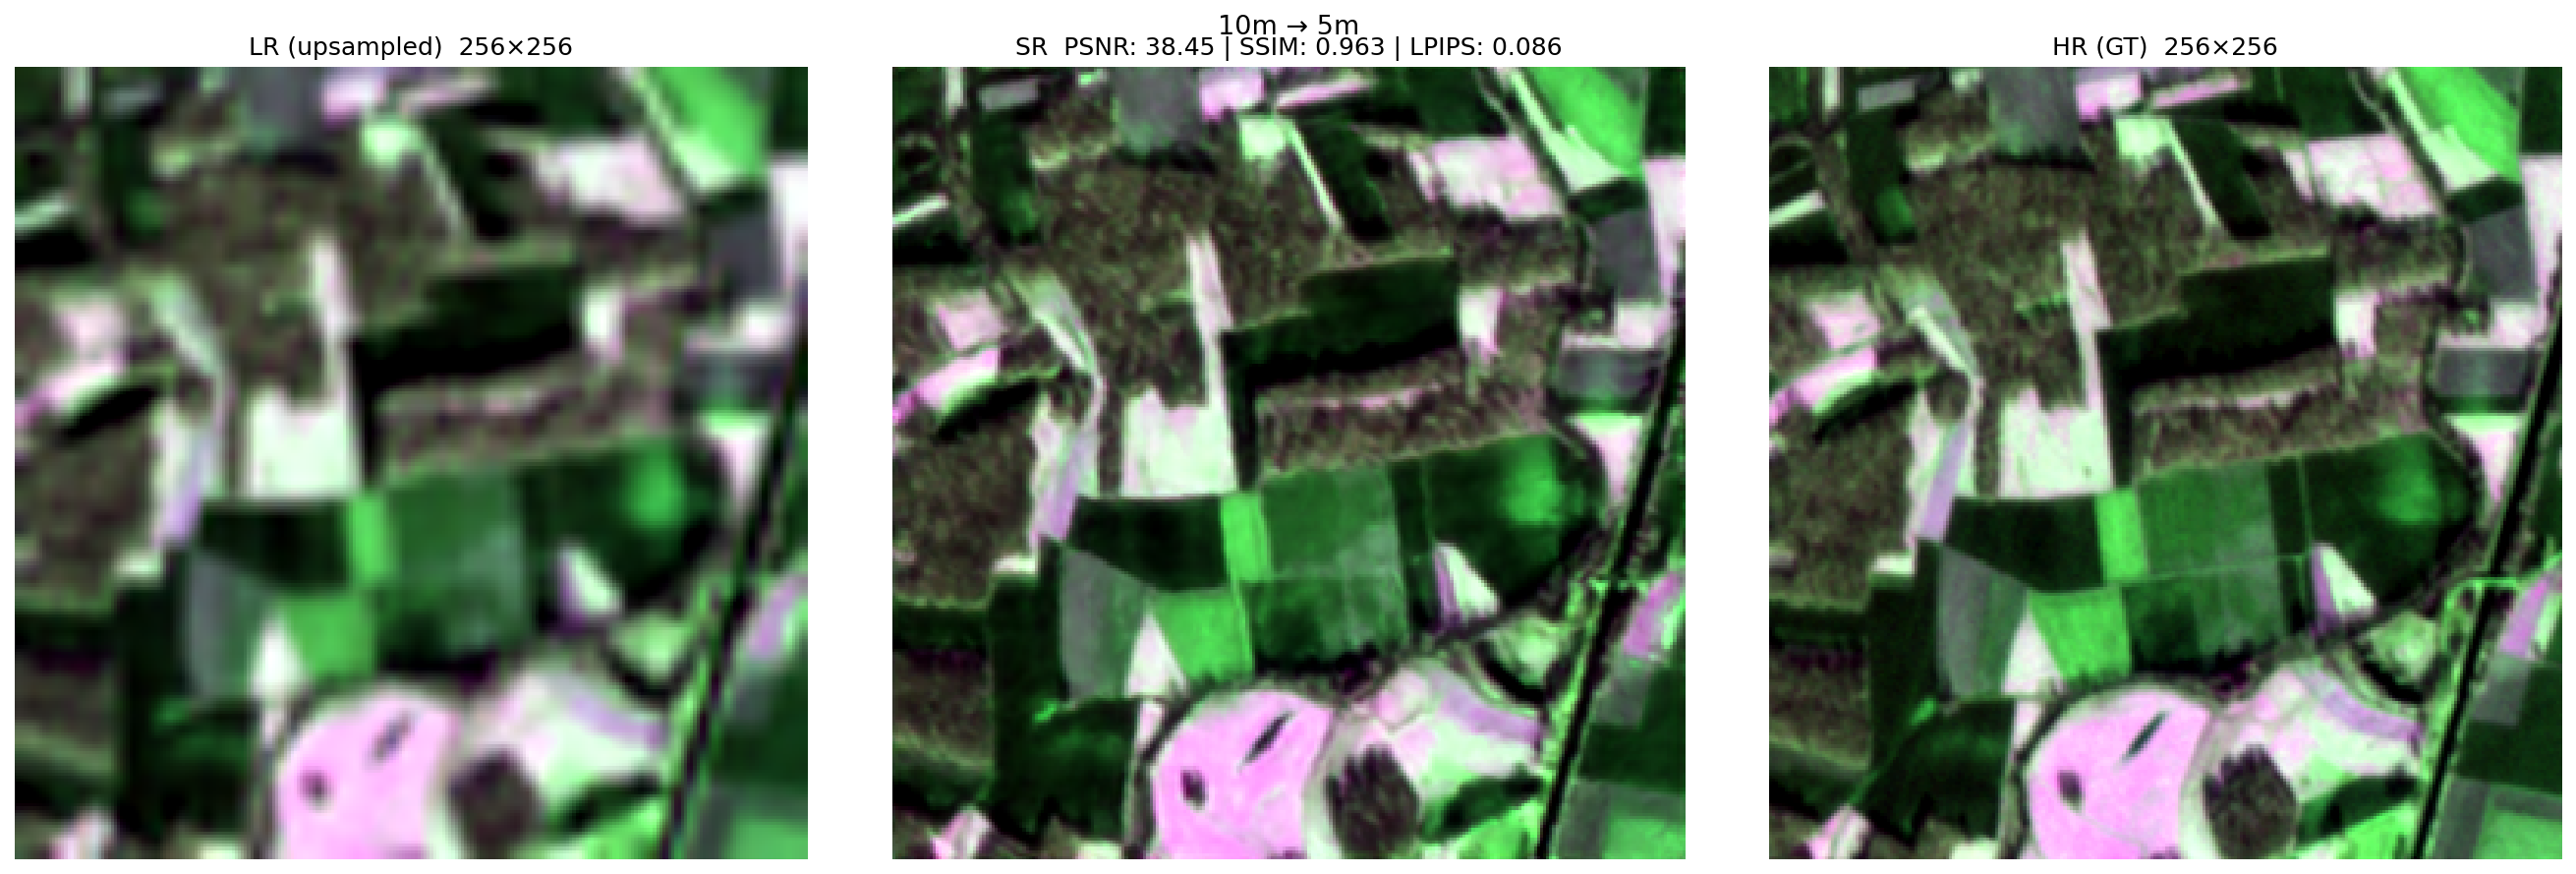

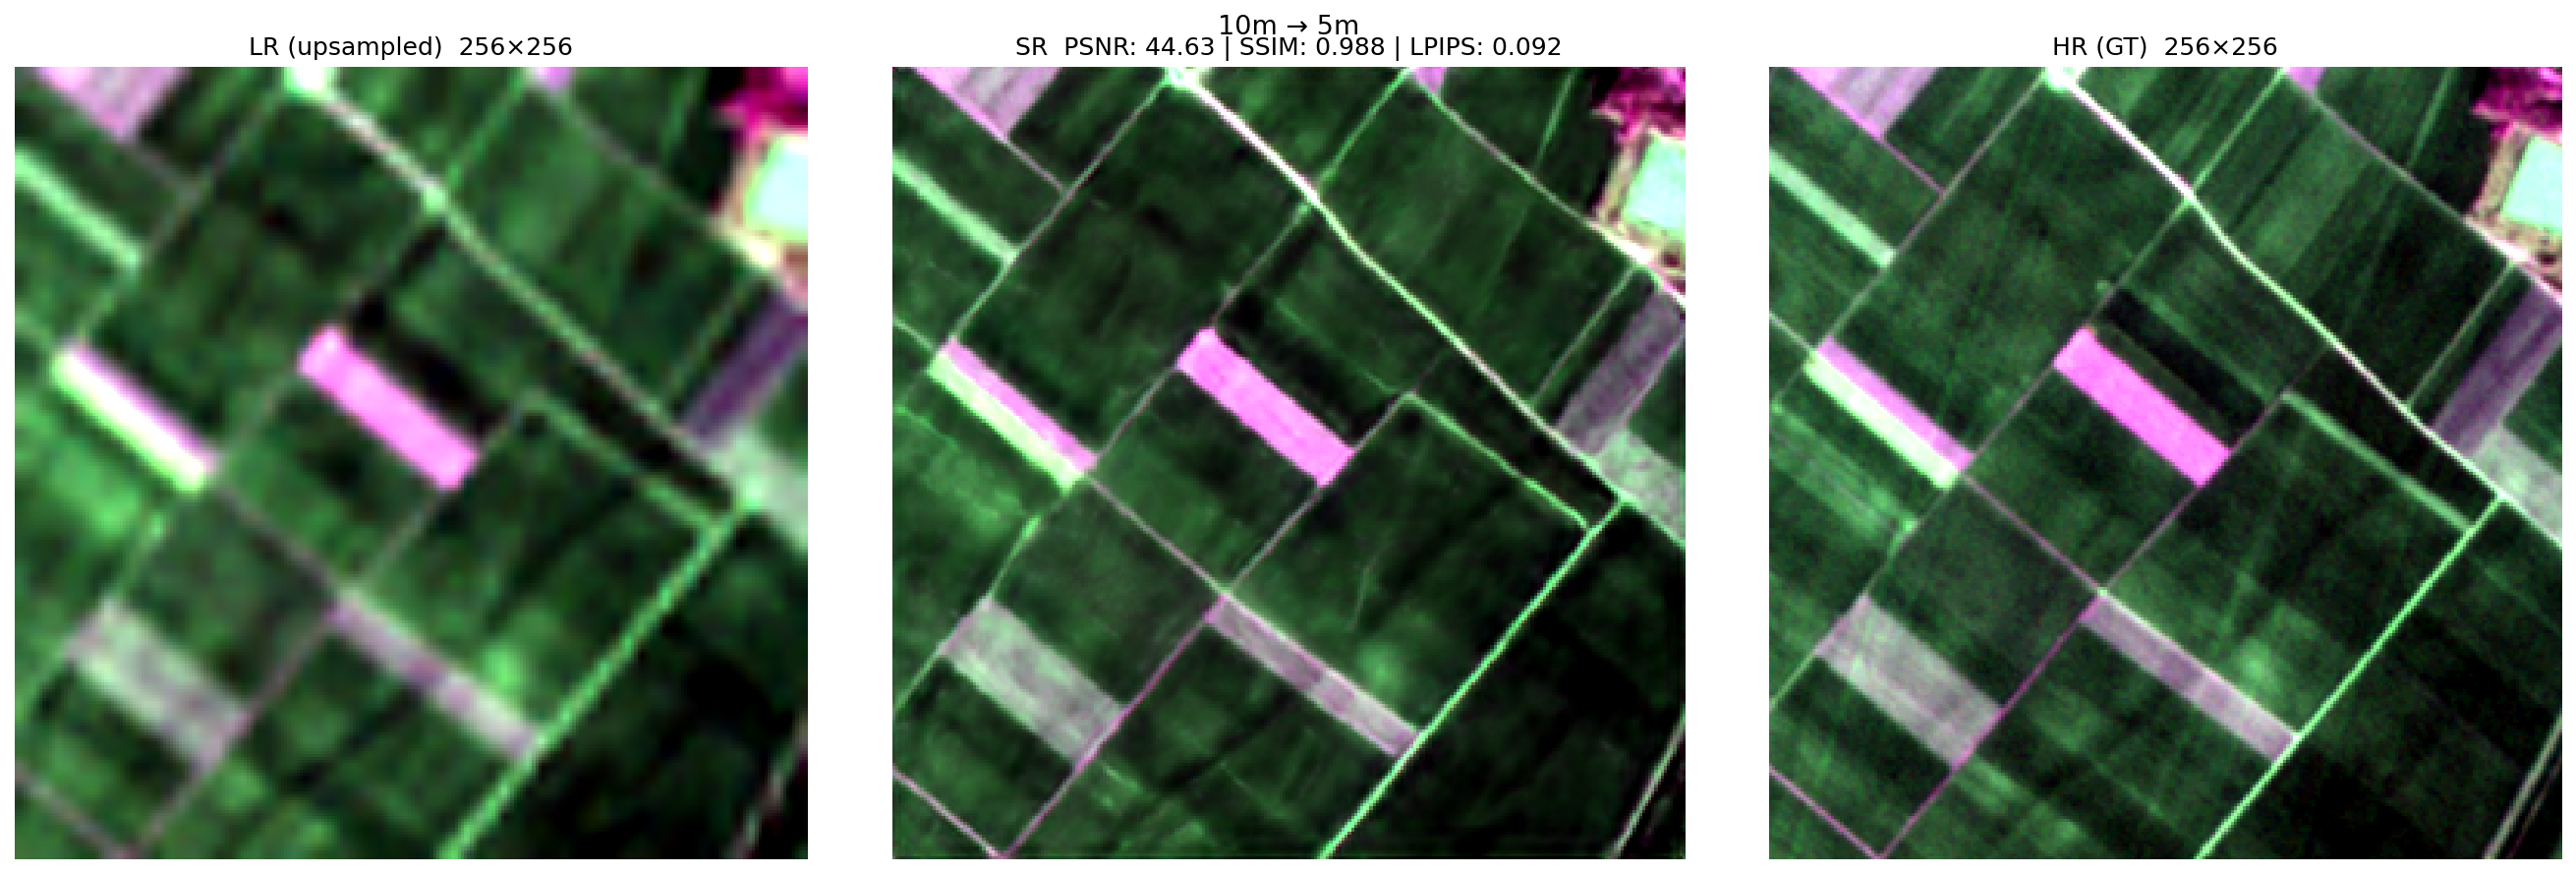

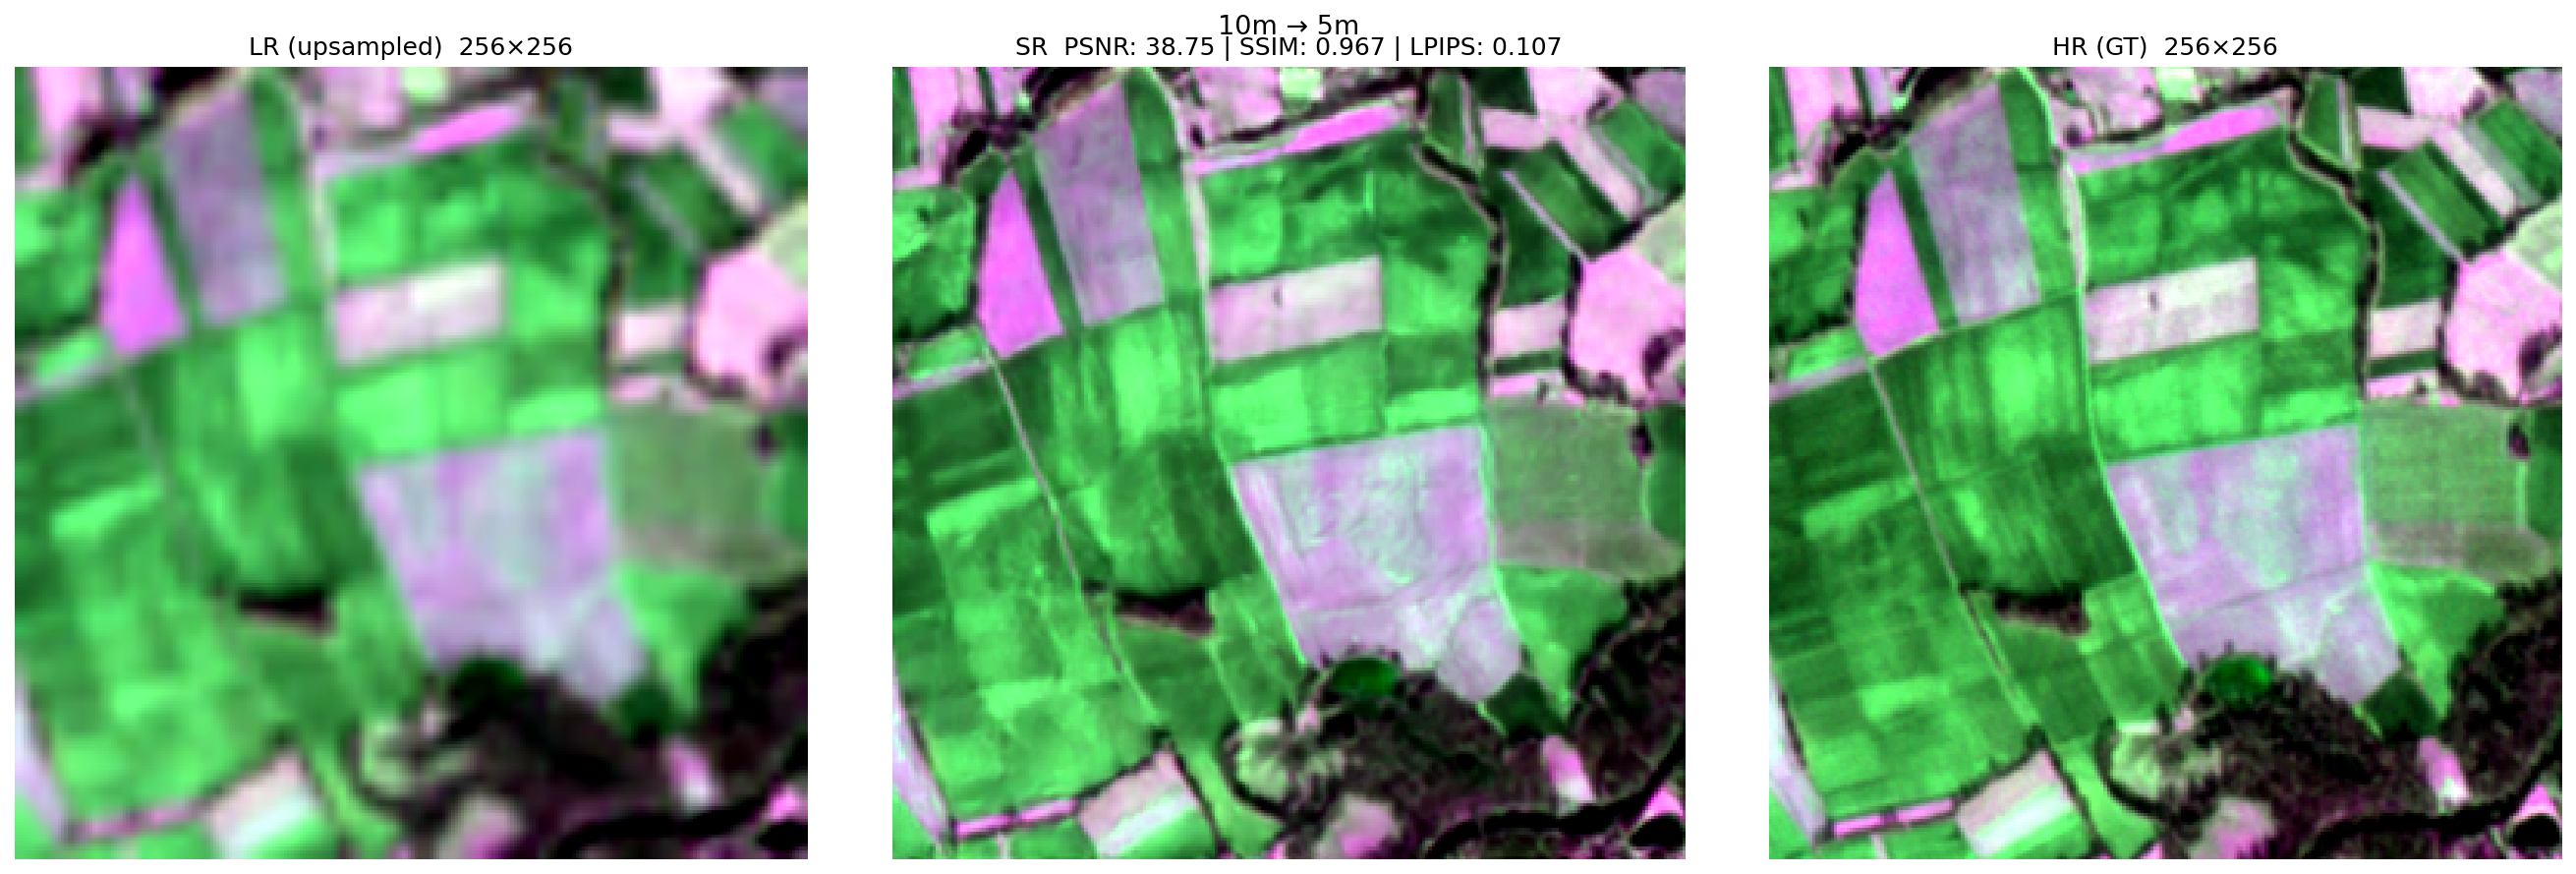

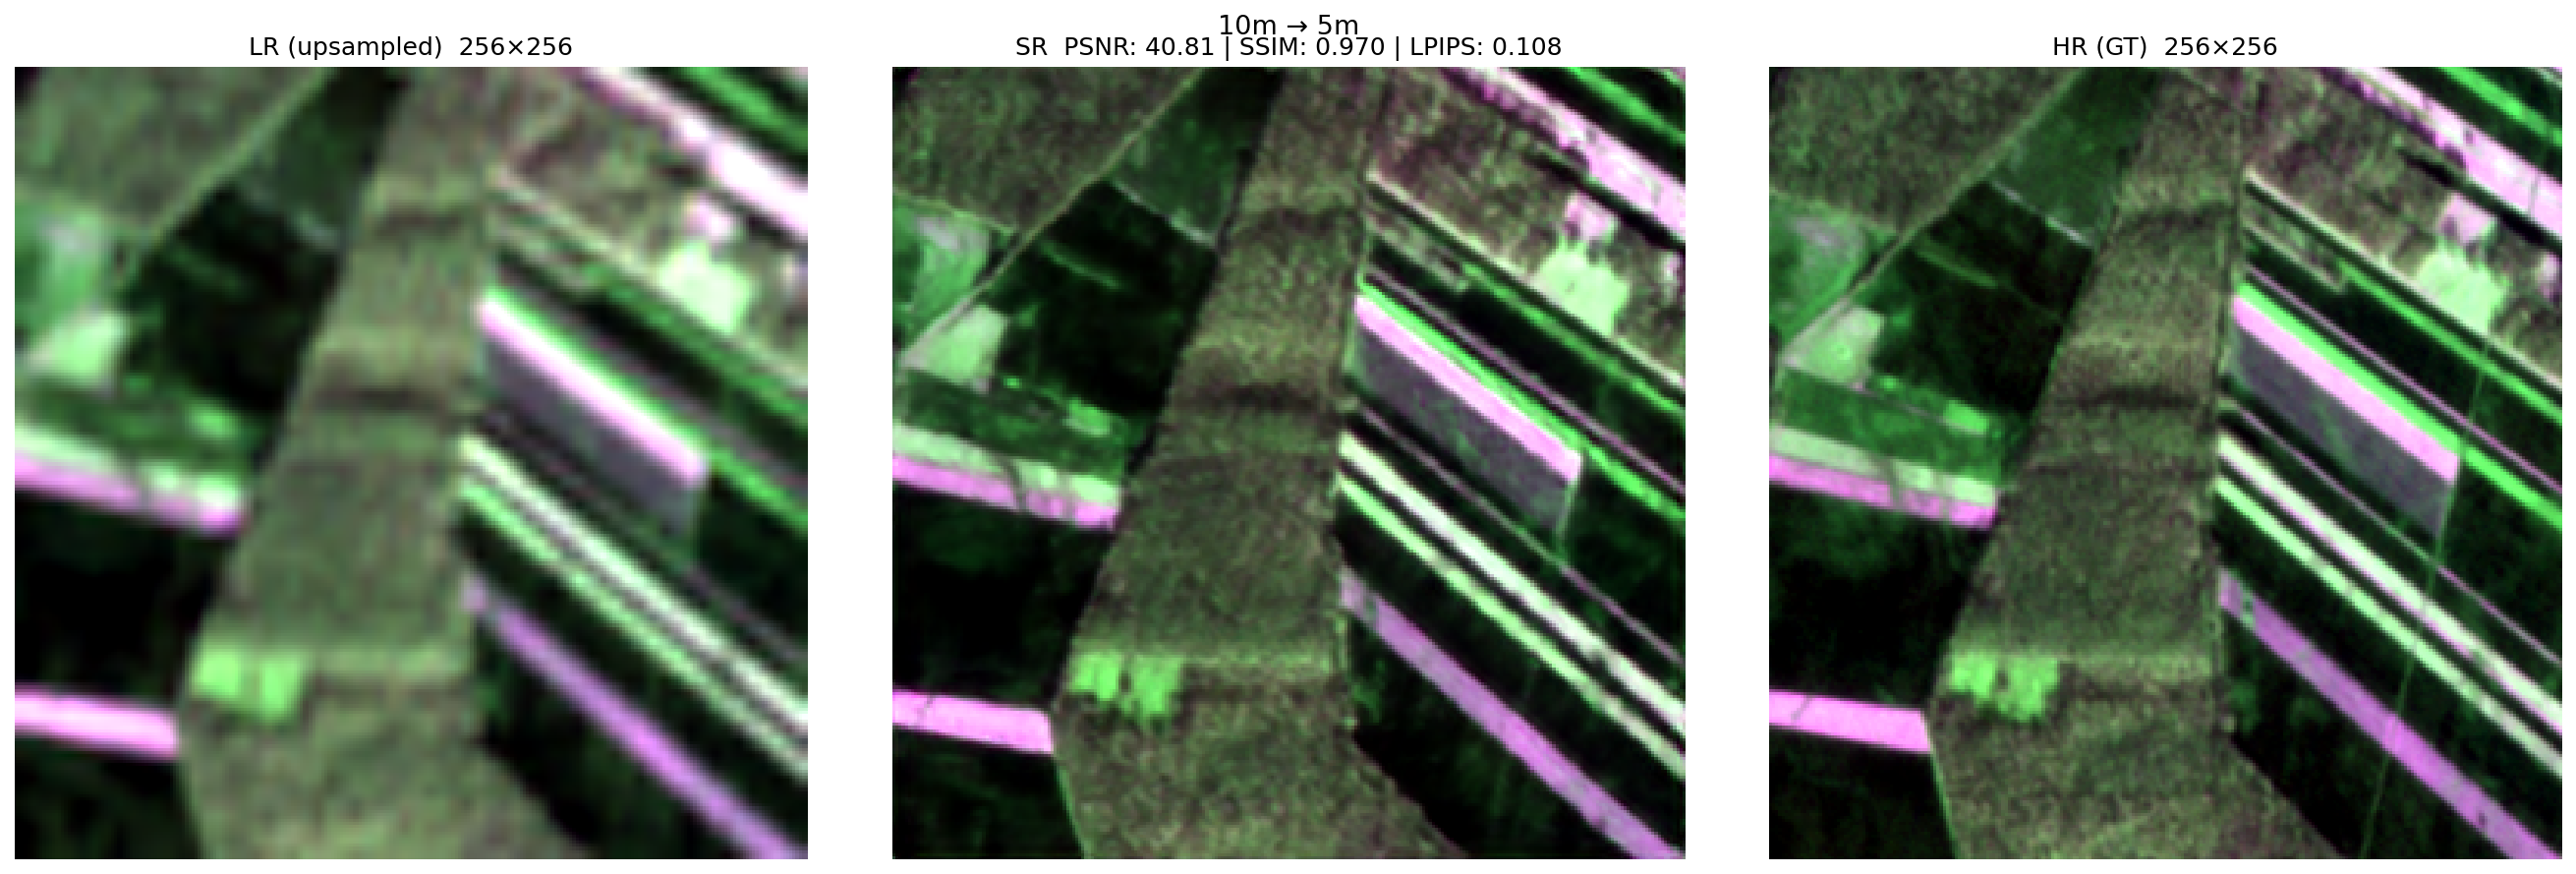

In [15]:
visualize_sr_triplets(gen, test_loader, band_combination='4x', num_samples=5, dpi=150)
